# Adding stochastic forces in cartesian coordinates

In this example, we add a stochastic force in the x and y direction to a free floating particle.

In [61]:
import rebound
sim = rebound.Simulation()
sim.add(m=1.) # free floating particle

We will be using the Leap-Frog integrator with a fixed timestep. It's important to point out that the default IAS15 integrator is not well suited for stochastic forces because it automatically reduces the timestep if it doesn't achieve an accuracy near machine precision. Because the stochastic forces are noisy by design, it might never converge or reduce the timestep to a very small value.

In [78]:
sim.integrator = "leapfrog"
sim.dt = 0.01

Next, we add the `stochastic_forces` module in REBOUNDx

In [63]:
import reboundx
rebx = reboundx.Extras(sim)
sto = rebx.load_force("stochastic_forces")
rebx.add_force(sto)

We can now turn on stochastic forces in the $x$ and $y$ direction for a particle. We do this by setting the particle's $\kappa_x$ (`kappa_x`) and $\kappa_y$ (`kappa_y`) fields to a finite value. These parameter determine the standard deviation of the stochastic forces in the given direction. The strengths can be different in the different directions, as shown in this example:

In [79]:
sim.particles[0].params["kappa_x"] = 5.0
sim.particles[0].params["kappa_y"] = 1.0 

We also need to specify the auto-correlation time of the stochastic forces. Note that the timestep needs to be smaller than the correlation time.

In [65]:
sim.particles[0].params["tau_kappa_x"] = 10.0
sim.particles[0].params["tau_kappa_y"] = 1.0

We can now run the simulation for some 100 time units and record the particle's position, velocity, and stochastic forces.

In [66]:
import numpy as np
times = np.linspace(0.,100, 1000)
xys = np.zeros((len(times),2))
vxvys = np.zeros((len(times),2))
forces = np.zeros((len(times),2))
for i, t in enumerate(times):
    sim.integrate(t)
    xys[i] = [sim.particles[0].x, sim.particles[0].y]
    vxvys[i] = [sim.particles[0].vx, sim.particles[0].vy]
    try:
        forces[i] = [sim.particles[0].params["stochastic_force_x"], sim.particles[0].params["stochastic_force_y"]]
    except:
        pass # not set before first timestep

Let's plot the positions and velocities as a function of time.

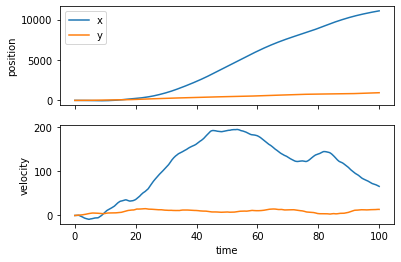

In [76]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,1, sharex=True)
#ax.set_aspect("equal")
ax[0].set_ylabel("position")
ax[0].plot(times, xys[:,0],label="x")
ax[0].plot(times, xys[:,1],label="y")
ax[1].set_xlabel("time")
ax[1].set_ylabel("velocity")
ax[1].plot(times, vxvys[:,0])
ax[1].plot(times, vxvys[:,1])
ax[0].legend();

We can see that the velocities undergo an random walk, whereas the positions undergo an integrated random walk. With the parameters that we have chosen, the diffusion coefficient (see e.g. [Rein and Papaloizou 2009](https://ui.adsabs.harvard.edu/abs/2009A%26A...497..595R/abstract)) in the $x$ direction is larger than in the $y$ direction, resulting in a faster random walk in the $x$ direction.

We can also plot the stochastic forces that have been applied to the particle. Notice the differences in both amplitude and correlation time.

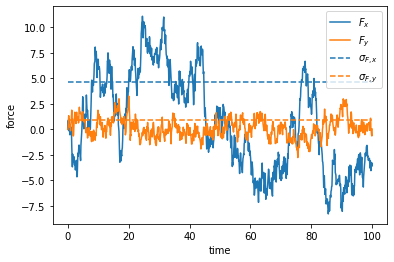

In [77]:
fig, ax = plt.subplots(1,1)
ax.set_xlabel("time")
ax.set_ylabel("force")
p=ax.plot(times, forces[:,0], label="$F_x$")
ax.hlines(np.std(forces[:,0]), xmin=times[0], xmax=times[-1],zorder=4, color=p[0].get_color(), ls="--", label="$\sigma_{F,x}$")
p=ax.plot(times, forces[:,1], label="$F_y$")
ax.hlines(np.std(forces[:,1]), xmin=times[0], xmax=times[-1],zorder=4, color=p[0].get_color(), ls="--", label="$\sigma_{F,y}$")
ax.legend();

The `stochastic_forces` module uses the internal pseudo random number generator of REBOUND. This means that by default, each simulation starts with a random seed. If you want to generate reproducible results, you can manually set the seed to the same value every time you run the simulation.

In [18]:
sim.rand_seed = 123